https://freedium.cfd/python.plainenglish.io/momentum-meets-volatility-a-data-driven-approach-to-strategy-optimization-683975dde552

In [1]:
# libraries
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools

In [ ]:
# functions
def calculate_cmo(df, period):
    """
    Calculate the Chande Momentum Oscillator (CMO) for a given DataFrame.

    The Chande Momentum Oscillator (CMO) is a technical momentum indicator developed by Tushar Chande.
    It measures the relative strength of recent gains versus recent losses over a specified period,
    providing values between -100 and +100. Positive values indicate upward momentum, negative values
    indicate downward momentum, and extreme values (above +50 or below -50) may signal overbought or
    oversold conditions. The CMO is used to identify trend strength and potential market reversals.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least a 'Close' price column.
    period : int
        The number of periods to use for the CMO calculation.

    Returns
    -------
    pandas.Series
        The CMO values for the given period.
    """
    diff = df['Close'].diff()
    gains = diff.where(diff > 0, 0).rolling(window=period).sum()
    losses = -diff.where(diff < 0, 0).rolling(window=period).sum()
    cmo = (gains - losses) / (gains + losses) * 100
    return cmo

def calculate_mass_index(df, period):
    """
    Calculate the Mass Index (MI) for a given DataFrame.

    The Mass Index (MI) is a technical analysis indicator developed by Donald Dorsey.
    It is designed to identify potential trend reversals by measuring the range between
    high and low prices over a specified period. The MI does not indicate the direction
    of the trend, but rather signals when a trend reversal may be likely due to price range expansion.
    A common signal is generated when the Mass Index rises above a certain threshold (often 27)
    and then falls below another threshold (often 26.5).

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least 'High' and 'Low' price columns.
    period : int
        The number of periods to use for the MI calculation.

    Returns
    -------
    pandas.Series
        The Mass Index values for the given period.
    """
    high_low_range = df['High'] - df['Low']
    ema_high_low = high_low_range.ewm(span=period).mean()
    mass_index = (high_low_range / ema_high_low).rolling(window=period).sum()
    return mass_index

def walk_forward_optimization_cmo_mi(df, start_year, end_year):
    results = []

    cmo_range = range(5, 101, 5)          # CMO lookback window
    mi_range = range(5, 101, 5)          # MI lookback window
    shift_range = range(1, 31)            # Signal shift values

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]

        best_params = None
        best_return = -np.inf

        for cmo_p, mi_p, shift_val in itertools.product(cmo_range, mi_range, shift_range):
            temp_train = train_data.copy()
            temp_train['CMO'] = calculate_cmo(temp_train, cmo_p)
            temp_train['MI'] = calculate_mass_index(temp_train, mi_p)

            entries = (temp_train['CMO'] > 0) & (temp_train['MI'] < temp_train['MI'].shift(shift_val))
            exits = (temp_train['CMO'] < 0) & (temp_train['MI'] > temp_train['MI'].shift(shift_val))

            shifted_entries = entries.shift(1).astype("boolean").fillna(False).to_numpy()
            shifted_exits = exits.shift(1).astype("boolean").fillna(False).to_numpy()

            portfolio = vbt.Portfolio.from_signals(
                close=temp_train['Open'],
                entries=shifted_entries,
                exits=shifted_exits,
                init_cash=100_000,
                fees=0.001,
                slippage=0.002,
                freq='D'
            )

            total_return = portfolio.total_return()
            if total_return > best_return:
                best_return = total_return
                best_params = (cmo_p, mi_p, shift_val)

        # Apply best parameters to test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)].copy()
        cmo_p, mi_p, shift_val = best_params
        yearly_data['CMO'] = calculate_cmo(yearly_data, cmo_p)
        yearly_data['MI'] = calculate_mass_index(yearly_data, mi_p)
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['CMO'] > 0) & (yearly_data['MI'] < yearly_data['MI'].shift(shift_val))
        exits = (yearly_data['CMO'] < 0) & (yearly_data['MI'] > yearly_data['MI'].shift(shift_val))

        shifted_entries = entries.shift(1).astype("boolean").fillna(False).to_numpy()
        shifted_exits = exits.shift(1).astype("boolean").fillna(False).to_numpy()

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Open'],
            entries=shifted_entries,
            exits=shifted_exits,
            init_cash=100_000,
            fees=0.001,
            slippage=0.002,
            freq='D'
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

In [3]:
# parameters
symbol = 'SYF'
start_date = '2015-01-01'
end_date = '2025-01-01'
risk_free_rate = 0.02

In [4]:
# download data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
# Perform walk-forward optimization
results = walk_forward_optimization_cmo_mi(df, 2016, 2025)

C:\Users\manuz\AppData\Local\Temp\ipykernel_18912\3671112871.py:111: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shifted_entries = entries.shift(1).fillna(False).astype(bool).to_numpy()
C:\Users\manuz\AppData\Local\Temp\ipykernel_18912\3671112871.py:112: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shifted_exits = exits.shift(1).fillna(False).astype(bool).to_numpy()
C:\Users\manuz\AppData\Local\Temp\ipykernel_18912\3671112871.py:111: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future ver

In [6]:
# Display results
print("\nWalk-Forward Optimization Results:")
print(results)


Walk-Forward Optimization Results:
   Year   Best_Params  Test_Return
0  2020  (30, 35, 16)     0.713196
1  2021  (25, 35, 15)     0.098589
2  2022  (25, 35, 15)    -0.167805
3  2023  (20, 30, 11)     0.019842
4  2024   (20, 35, 3)     0.217222
5  2025   (20, 5, 12)     0.000000


In [7]:
# Combine yearly signals into one backtest
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    cmo_p, mi_p, shift_val = row['Best_Params']
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)].copy()
    yearly_data['CMO'] = calculate_cmo(yearly_data, cmo_p)
    yearly_data['MI'] = calculate_mass_index(yearly_data, mi_p)
    yearly_data = yearly_data[yearly_data.index.year == year]

    entries = (yearly_data['CMO'] > 0) & (yearly_data['MI'] < yearly_data['MI'].shift(shift_val))
    exits = (yearly_data['CMO'] < 0) & (yearly_data['MI'] > yearly_data['MI'].shift(shift_val))

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

In [8]:
# Filter for testing period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

In [9]:
# Final portfolio
shifted_entries = combined_entries.shift(1).astype("boolean").fillna(False).to_numpy()
shifted_exits = combined_exits.shift(1).astype("boolean").fillna(False).to_numpy()
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

In [10]:
# Get core metrics
car = portfolio.annualized_return()
vol = portfolio.annualized_volatility()
max_dd = abs(portfolio.max_drawdown())

# Adjusted CAR using Sharpe-style formula (based on volatility)
adj_car_sharpe = (car - risk_free_rate) / vol if vol != 0 else np.nan

# Adjusted CAR using Calmar-style formula (based on drawdown)
adj_car_calmar = car / max_dd if max_dd != 0 else np.nan

In [ ]:
# Initialize variables to track exposure calculation
in_position = False
exposure_days = 0
total_days = len(df)

# Loop through the entries and exits to calculate exposure
for i in range(1, len(df)):
    if combined_entries.iloc[i] and not in_position:  # Entry signal (enter position)
        in_position = True
        entry_day = i  # Track entry day
    elif combined_exits.iloc[i] and in_position:  # Exit signal (exit position)
        in_position = False
        exit_day = i  # Track exit day
        exposure_days += exit_day - entry_day  # Count days in position

# If the last position is still open (i.e., no exit signal), consider the last day of the dataset
if in_position:
    exposure_days += total_days - entry_day  # Count remaining days in position

# Calculate exposure as percentage of time in position
exposure_percentage = (exposure_days / total_days) * 100

C:\Users\manuz\AppData\Local\Temp\ipykernel_18912\707903373.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if combined_entries[i] and not in_position:  # Entry signal (enter position)
C:\Users\manuz\AppData\Local\Temp\ipykernel_18912\707903373.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif combined_exits[i] and in_position:  # Exit signal (exit position)


In [12]:
stats = portfolio.stats()
stats['CAR'] = f"{car:.2%}"
stats['Adjusted CAR (Sharpe-style)'] = f"{adj_car_sharpe:.2%}"
stats['Adjusted CAR (Calmar-style)'] = f"{adj_car_calmar:.2%}"
stats['Market Time Exposure'] = f"{exposure_percentage:.2f}%"
print(stats)

Start                          2020-01-02 00:00:00
End                            2024-12-31 00:00:00
Period                          1258 days 00:00:00
Start Value                               100000.0
End Value                            243342.939248
Total Return [%]                        143.342939
Benchmark Return [%]                    106.024893
Max Gross Exposure [%]                       100.0
Total Fees Paid                         6223.94389
Max Drawdown [%]                          42.81063
Max Drawdown Duration            896 days 00:00:00
Total Trades                                    17
Total Closed Trades                             17
Total Open Trades                                0
Open Trade PnL                                 0.0
Win Rate [%]                             47.058824
Best Trade [%]                           45.049903
Worst Trade [%]                         -14.072502
Avg Winning Trade [%]                    20.246065
Avg Losing Trade [%]           

In [13]:
# Plot equity curve
portfolio.plot().show()

In [14]:
# Buy and hold strategy for comparison
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Open']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf.stats())

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           206024.893082
Total Return [%]                       106.024893
Benchmark Return [%]                   106.024893
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        63.224276
Max Drawdown Duration           719 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      106024.893082
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


In [15]:
# Evaluate the Performance of Trading Strategy Relative to a Benchmark

from scipy.stats import linregress

# Calculate Alpha, Beta, and Correlation with a Buy and Hold (B&H) strategy
portfolio_returns = portfolio.returns()
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
df_holding = df['Open']
benchmark = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
benchmark_returns = benchmark.returns()

# Ensure returns are aligned
portfolio_returns, benchmark_returns = portfolio_returns.align(benchmark_returns, join='inner')

# Calculate Beta and alpha using linear regression
slope, intercept, r_value, _, _ = linregress(benchmark_returns, portfolio_returns)
beta = slope
alpha = intercept

# Calculate Correlation
correlation = portfolio_returns.corr(benchmark_returns)

# Display results
print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")
print(f"Correlation: {correlation:.4f}")

Alpha: 0.0004
Beta: 0.5237
Correlation: 0.7223


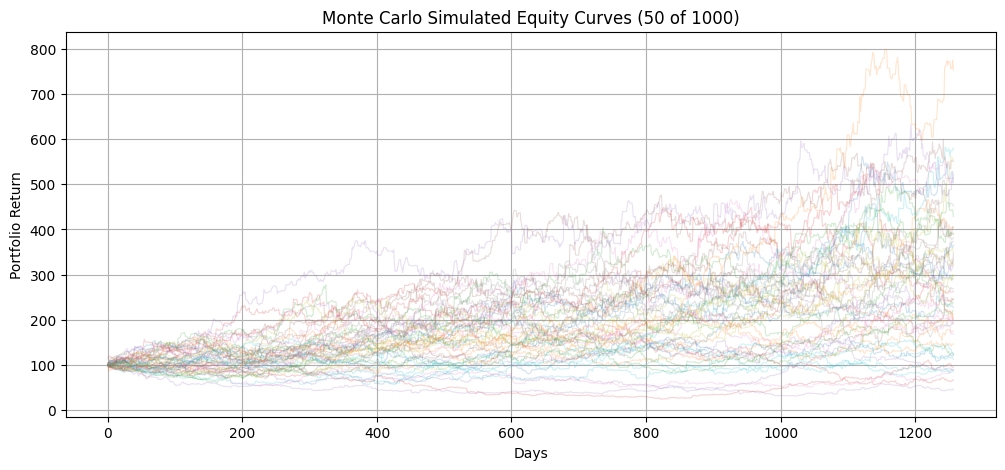

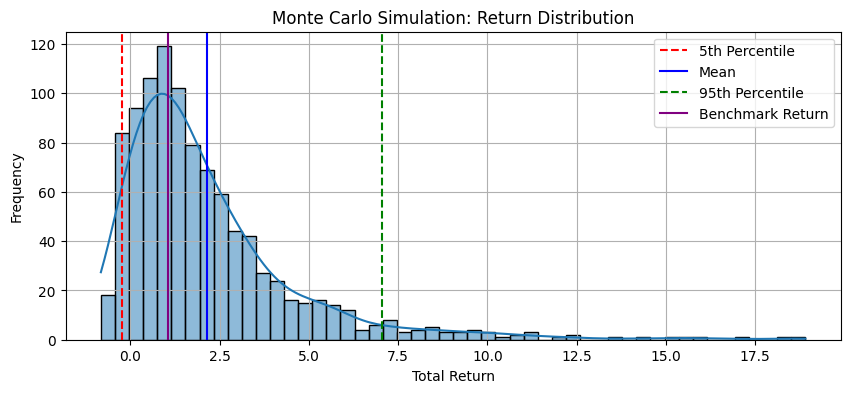

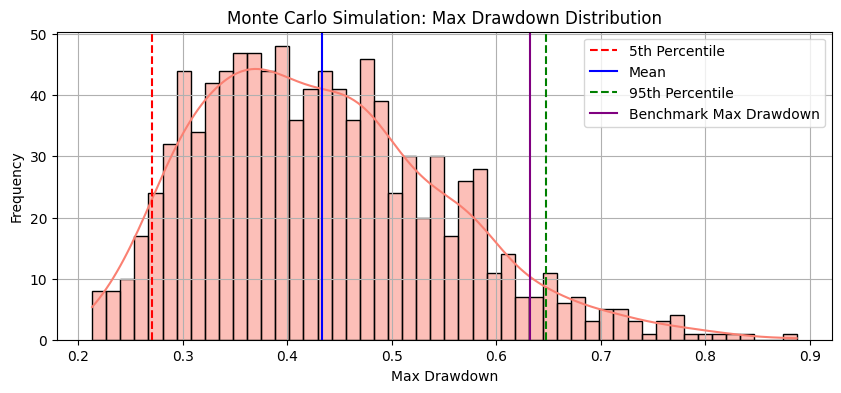

Monte Carlo Summary (1000 Simulations):
Mean Final Return: 215.79%
Median Final Return: 144.44%
5th Percentile Return: -23.63%
95th Percentile Return: 703.73%
Average Max Drawdown: 43.37%
Average Sharpe Ratio: 0.71
Number of simulations with return less than benchmark: 387
Number of simulations with max drawdown greater than benchmark: 61


In [19]:
# ------------------ ADVANCED MONTE CARLO SIMULATION ------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters
n_simulations = 1000
n_days = len(portfolio.returns())
init_value = 100

# Get daily returns from the backtest
returns = portfolio.returns().copy().values  # convert to numpy

# Prepare to store metrics
equity_paths = []
drawdowns = []
final_returns = []
sharpe_ratios = []
volatilities = []

# Define Benchmark Return and Max Drawdown
benchmark_return = 1.0602
benchmark_drawdown = 0.6322

# Counters for number of simulations below benchmark return or above benchmark drawdown
below_benchmark_return_count = 0
above_benchmark_drawdown_count = 0

# Simulate full paths
for _ in range(n_simulations):
    sampled_returns = np.random.choice(returns, size=n_days, replace=True)
    equity = init_value * np.cumprod(1 + sampled_returns)

    equity_paths.append(equity)
    daily_returns = np.diff(equity) / equity[:-1]

    max_dd = np.max(1 - equity / np.maximum.accumulate(equity))
    total_return = (equity[-1] / init_value) - 1
    volatility = np.std(daily_returns)
    sharpe = np.mean(daily_returns) / (volatility + 1e-8) * np.sqrt(252)  # Avoid div by zero

    drawdowns.append(max_dd)
    final_returns.append(total_return)
    volatilities.append(volatility)
    sharpe_ratios.append(sharpe)

    # Count simulations below benchmark return and above benchmark drawdown
    if total_return < benchmark_return:
        below_benchmark_return_count += 1
    if max_dd > benchmark_drawdown:
        above_benchmark_drawdown_count += 1

# Plot: Sampled equity paths
plt.figure(figsize=(12, 5))
for i in range(50):  # only plot 50 to avoid clutter
    plt.plot(equity_paths[i], alpha=0.2, linewidth=0.8)
plt.title('Monte Carlo Simulated Equity Curves (50 of 1000)')
plt.xlabel('Days')
plt.ylabel('Portfolio Return')
plt.grid(True)
plt.show()

# Plot: Histogram of final returns with benchmark line
plt.figure(figsize=(10, 4))
sns.histplot(final_returns, bins=50, kde=True)

# Add percentile, mean, and benchmark lines
plt.axvline(np.percentile(final_returns, 5), color='red', linestyle='--', label='5th Percentile')
plt.axvline(np.mean(final_returns), color='blue', linestyle='-', label='Mean')
plt.axvline(np.percentile(final_returns, 95), color='green', linestyle='--', label='95th Percentile')
plt.axvline(benchmark_return, color='purple', linestyle='-', label='Benchmark Return')  # Benchmark Line

plt.title('Monte Carlo Simulation: Return Distribution')
plt.xlabel('Total Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Histogram of drawdowns with benchmark line
plt.figure(figsize=(10, 4))
sns.histplot(drawdowns, bins=50, kde=True, color='salmon')

# Add percentile, mean, and benchmark lines
plt.axvline(np.percentile(drawdowns, 5), color='red', linestyle='--', label='5th Percentile')
plt.axvline(np.mean(drawdowns), color='blue', linestyle='-', label='Mean')
plt.axvline(np.percentile(drawdowns, 95), color='green', linestyle='--', label='95th Percentile')
plt.axvline(benchmark_drawdown, color='purple', linestyle='-', label='Benchmark Max Drawdown')  # Benchmark Line

plt.title('Monte Carlo Simulation: Max Drawdown Distribution')
plt.xlabel('Max Drawdown')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Show summary stats
print("Monte Carlo Summary (1000 Simulations):")
print(f"Mean Final Return: {np.mean(final_returns):.2%}")
print(f"Median Final Return: {np.median(final_returns):.2%}")
print(f"5th Percentile Return: {np.percentile(final_returns, 5):.2%}")
print(f"95th Percentile Return: {np.percentile(final_returns, 95):.2%}")
print(f"Average Max Drawdown: {np.mean(drawdowns):.2%}")
print(f"Average Sharpe Ratio: {np.mean(sharpe_ratios):.2f}")

# Print number of simulations below benchmark return and above benchmark max drawdown
print(f"Number of simulations with return less than benchmark: {below_benchmark_return_count}")
print(f"Number of simulations with max drawdown greater than benchmark: {above_benchmark_drawdown_count}")